In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
# from config import DEVICE
import SyncTwin
from util import train_utils, io_utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds

# Fig3 A

In [5]:
seed = 100
sim_id = 'sync1'
model_id = '-prognostic-linear'

base_path_model = '../models/{}-seed-'.format(sim_id) + str(seed) + model_id
base_path_plot = '../plots/{}-seed-'.format(sim_id) + str(seed)+ model_id
base_path_data = '../data/{}-seed-'.format(sim_id) + str(seed)
train_utils.create_paths(base_path_model, base_path_plot, base_path_data)
plot_path = base_path_plot + '/unit-{}-dim-{}-{}.png'
data_path = base_path_data + '/{}-{}.{}'
data_path2 = base_path_data + '/{}.{}'

# loading config and data
print('loading data')
n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster = io_utils.load_config(data_path)
x_full, t_full, mask_full, batch_ind_full, y_full, y_control, y_mask_full, m, sd, treatment_effect = io_utils.load_tensor(data_path, 'test')


loading data


In [6]:
best_model_path = base_path_model + '/best-{}.pth'
enc = SyncTwin.RegularEncoder(input_dim=3, hidden_dim=20)
dec = SyncTwin.RegularDecoder(hidden_dim=enc.hidden_dim, output_dim=enc.input_dim, max_seq_len=train_step)
dec_Y = SyncTwin.LinearDecoder(hidden_dim=enc.hidden_dim, output_dim=y_full.shape[-1],
                                       max_seq_len=step - train_step)
if model_id.find('none') > 0:
    nsc = SyncTwin.SyncTwin(n_units, n_treated, tau=1, reg_B=0., lam_express=1., lam_recon=1., lam_prognostic=0., encoder=enc, decoder=dec)
else:
    nsc = SyncTwin.SyncTwin(n_units, n_treated, tau=1, reg_B=0., lam_express=1., lam_recon=1., lam_prognostic=0., encoder=enc, decoder=dec, decoder_Y=dec_Y)

train_utils.load_nsc(nsc, x_full, t_full, mask_full, batch_ind_full, model_path=best_model_path.format('nsc.pth'))


In [7]:
def get_treatment_effect(nsc, batch_ind_full, y_full, y_control, y_pre_control,itr=500):
    y_hat_list = list()
    y_hat_list2 = list()
    for i in range(itr):
        with torch.no_grad():
            B_reduced = nsc.get_B_reduced(batch_ind_full)
            y_hat = torch.matmul(B_reduced, y_control)
            y_pre_hat = torch.matmul(B_reduced, y_pre_control)
            if torch.sum(torch.isinf(y_hat)).item() == 0:
                y_hat_list.append(y_hat)
            if torch.sum(torch.isinf(y_pre_hat)).item() == 0:
                y_hat_list2.append(y_pre_hat)

    y_hat_mat = torch.stack(y_hat_list, dim=-1)
    y_hat_mat[torch.isinf(y_hat_mat)] = 0.
    y_hat2 = torch.mean(y_hat_mat, dim=-1)
    
    y_pre_hat_mat = torch.stack(y_hat_list2, dim=-1)
    y_pre_hat_mat[torch.isinf(y_pre_hat_mat)] = 0.
    y_pre_hat2 = torch.mean(y_pre_hat_mat, dim=-1)
    
    return (y_full - y_hat2)[:, nsc.n_unit:, :],  y_hat2, y_pre_hat2[:, n_units:, 0]

In [8]:
y_pre_control = x_full[:, :n_units, 2][:, :, None]
effect_est, y_hat, y_pre_hat = get_treatment_effect(nsc, batch_ind_full, y_full, y_control, y_pre_control)

In [9]:
y_pre_test = x_full[:, n_units:, 2]

In [10]:
err_post = torch.mean(torch.abs(treatment_effect - effect_est), dim=0).squeeze().cpu().numpy()

In [11]:
err_pre = torch.mean(torch.abs(y_pre_hat - y_pre_test), dim=0).squeeze().cpu().numpy()

In [12]:
n_reject = []
n_reject_sd = []
error_kept = []
error_kept_sd = []
pct_ok = []
t_list = np.linspace(0.05, 0.6, 100)
for t in t_list:
    p = np.sum(err_pre < t)/200
    err = err_post[err_pre < t]
    pct_ok.append(np.sum(err < t) / len(err))
    n_reject.append(p * 100)
    n_reject_sd.append(np.sqrt(p * (1-p) / 200) * 100)
    error_kept.append(np.mean(err))
    error_kept_sd.append(np.std(err) / np.sqrt(len(err) * 5))

n_reject = np.array(n_reject)
n_reject_sd = np.array(n_reject_sd)
error_kept = np.array(error_kept)
error_kept_sd = np.array(error_kept_sd)

<Figure size 432x216 with 0 Axes>

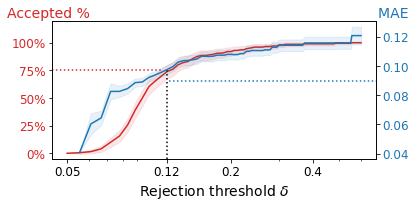

In [13]:
import matplotlib.ticker as mtick
f = plt.figure(figsize=(6,3))

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(6,3))

color = 'tab:red'
ax1.set_xlabel('Rejection threshold $\delta$')
ax1.set_xscale('log')
ax1.set_xticks([0.05,  0.116, 0.2, 0.4])
ax1.set_xticklabels([0.05, 0.12, 0.2, 0.4])
ax1.set_ylabel('Accepted %', color=color, position=(-1,1), rotation=0, ha='left')
ax1.plot(t_list, n_reject, color=color)
ax1.fill_between(t_list, n_reject-2*n_reject_sd, n_reject+2*n_reject_sd, color=color, alpha=0.1)
ax1.axhline(y=75, xmin=-0.05, xmax=0.34, color=color, ls=':')
ax1.axvline(ymax=0.65, ymin=0, x=0.1166, color='black', ls=':')
ax1.axhline(y=65, xmin=0.36, xmax=1.8, color='tab:blue', ls=':')
ax1.set_yticks([0, 25, 50, 75, 100])
# ax.set_yticklabels(np.round(custom_ticks, 1))

ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylim((-5,120.05))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_xscale('log')
color = 'tab:blue'
ax2.set_ylabel('MAE ', color=color, position=(-1,1.1), rotation=0, ha='right')  # we already handled the x-label with ax1
ax2.plot(t_list, error_kept, color=color)
ax2.fill_between(t_list, error_kept-2*error_kept_sd, error_kept+2*error_kept_sd, color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Fig3_A.png', dpi=300)
# plt.show()

# Fig3 B

#### Note:
Please manually update [`results/confounder_err.csv`](../results/confounder_err.csv) and [`results/confounder_sd.csv`](../results/confounder_sd.csv) manually after running experiments:

<br/>

* `_err` file contains MAE experiment mean vales.
* `_sd` file contains MAE experiment estimated standard deviation values.

<br/>

* Values in column 1 comes from the file `Tab2_C3_MAE.txt` (generated by `Tab2.sh`).
* Values in columns 2 and 3 come from `Fig3_C2_MAE.txt` and `Fig3_C3_MAE.txt` respectively (generated by  `Fig3.sh`).

In [15]:
err = pds.read_csv('../results/confounder_err.csv')
err

,0,1,2,3
0,SyncTwin,0.119,0.109,0.148
1,SC,0.149,0.138,0.260
2,MC-NNM,0.226,0.345,0.775
3,CFRNet,0.139,0.158,0.241
4,1NN,1.614,1.636,1.813
5,GP,0.561,0.563,0.554
6,RSC,0.321,0.322,0.322
7,CRN,0.273,0.363,0.458


In [16]:
sdd = pds.read_csv('../results/confounder_sd.csv')
sdd

,0,1,2,3
0,SyncTwin,0.008,0.007,0.016
1,SC,0.018,0.013,0.022
2,MC-NNM,0.011,0.018,0.042
3,CFRNet,0.007,0.009,0.016
4,1NN,0.078,0.088,0.104
5,GP,0.036,0.036,0.036
6,RSC,0.019,0.019,0.019
7,CRN,0.021,0.023,0.024


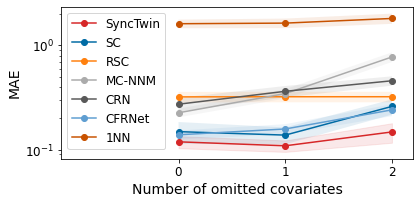

In [17]:
plt.style.use('tableau-colorblind10')

fig, ax1 = plt.subplots(figsize=(6,3))

for model in ['SyncTwin', 'SC', 'RSC', 'MC-NNM', 'CRN', 'CFRNet', '1NN']:
    err_sub = err[err['0'] == model][['1', '2', '3']].values[0, :]
    sd_sub = sdd[sdd['0'] == model][['1', '2', '3']].values[0, :]
    x = ['0', '1', '2']
    if model != 'SyncTwin':
        ax1.plot(x, err_sub, 'o-', label=model)
        ax1.fill_between(x, err_sub-1.96*sd_sub, err_sub+1.96*sd_sub, alpha=0.1)
    else:
        ax1.plot(x, err_sub, 'o-', label=model, color='tab:red')
        ax1.fill_between(x, err_sub-1.96*sd_sub, err_sub+1.96*sd_sub, alpha=0.1, color='tab:red')

    ax1.set_yscale('log')
    plt.xlim(-1.1, 2.2)

ax1.set_ylabel('MAE')
ax1.set_xlabel('Number of omitted covariates')

plt.legend()
fig.tight_layout()

plt.savefig('Fig3_B.png', dpi=300)
